## Learned Methods for Reconstruction
In this notebook we'll look at methods which use outside training data to perform denoising. The high-level idea is that by utilizing existing clean images, we can identify structures common between the noisy and clean data, which we'll use to do reconstruction.

The first approach we'll look at, dictionary learning, is the more straightforward and interpretable of the two. Our second method will utilize a neural network, which will be pretrained and is mainly for demonstration purposes.

First, to start off, let's load our test image, as usual.

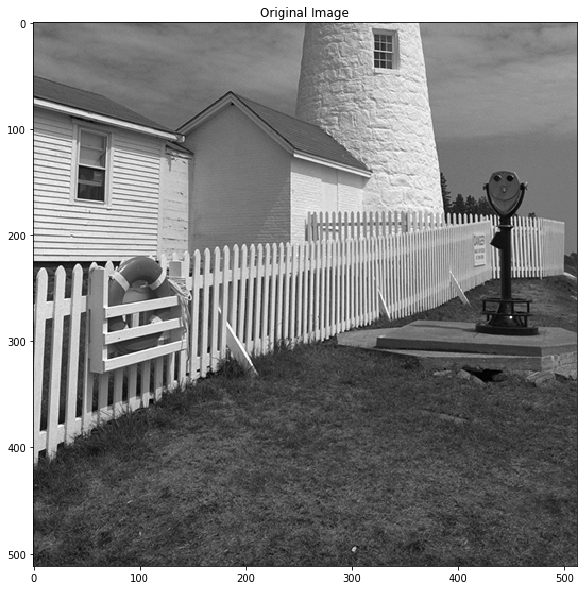

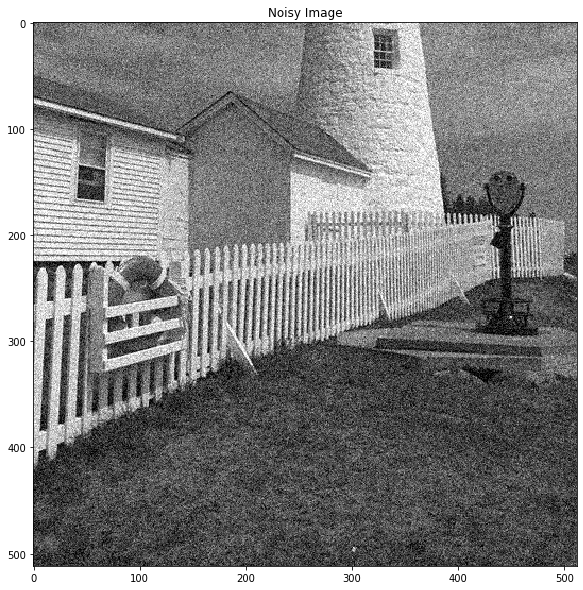

In [1]:
import imageio, os, utils
import numpy as np
import matplotlib.pyplot as plt
import corruption_models
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

cwd = os.getcwd()
image_folder = cwd + "/images/"
example_image_path = image_folder + "lighthouse.png"
test_image = utils.normalize_to_01(imageio.imread(example_image_path))
noise_sigma = 0.1
noisy_image = corruption_models.add_gaussian_noise(test_image, sigma=noise_sigma)

fig = plt.figure()
plt.imshow(test_image, cmap='gray'); plt.title('Original Image')
plt.show()

fig = plt.figure()
plt.imshow(noisy_image, cmap='gray'); plt.title('Noisy Image')
plt.show()


## Dictionary Learning
The idea behind dictionary learning is that we can use a corpus of images (or just a single other image) to learn a set of components, which can then be used to denoise another image. Usually this is done in a patchwise manner, so a noisy patch is denoised with a combination of example patches, and then the patches are recombined afterwards.

We're going to start off by loading in three different images, which you can try to use to learn a dictionary to denoise the lighthouse. 

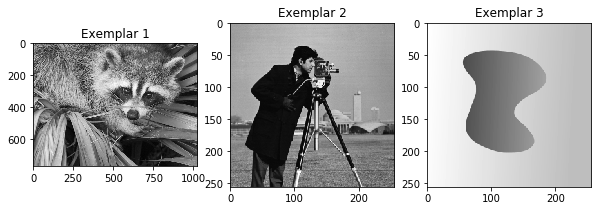

In [8]:
from scipy.misc import face    # Research is ongoing re: why scipy.misc.face is a raccoon.
exemplar_1 = utils.normalize_to_01(face(gray=True))

exemplar_2_path = image_folder + "cameraman.jpg"
exemplar_2 = utils.normalize_to_01(imageio.imread(exemplar_2_path))

exemplar_3_path = image_folder + "blob.png"
exemplar_3 = utils.normalize_to_01(imageio.imread(exemplar_3_path, pilmode="L"))

_, ax_array = plt.subplots(1,3)
ax_array[0].imshow(exemplar_1, vmin=0, vmax=1, cmap='gray')
ax_array[0].set_title('Exemplar 1')
ax_array[1].imshow(exemplar_2, vmin=0, vmax=1, cmap='gray')
ax_array[1].set_title('Exemplar 2')
ax_array[2].imshow(exemplar_3, vmin=0, vmax=1, cmap='gray')
ax_array[2].set_title('Exemplar 3')
plt.show()

### Normalization
Before we learn the dictionary, we want to normalize the image we're interested in. After that, we'll learn a dictionary and show the atoms we learned.

In [38]:
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

def normalize_data(input_data):
    normalized = input_data - np.mean(input_data, axis=0)
    normalized /= np.std(normalized, axis=0)
    return normalized

# These are tunable parameters
patch_size = (8, 8)
sparsity_alpha = 10  # How sparse do we want the image to be in our transform domain?
n_learning_iterations = 500
n_dictionary_elements = 200

image_shape = np.shape(noisy_image)

patch_data = extract_patches_2d(exemplar_3, patch_size) # This will give a warning - that's okay.
patch_data = patch_data.reshape(patch_data.shape[0], -1) # Flatten the 2d patches into vectors
normalized_patches = normalize_data(patch_data)


patch_dictionary = MiniBatchDictionaryLearning(n_components=n_dictionary_elements, alpha=dictionary_alpha, n_iter=n_learning_iterations)
learned_dictionary = patch_dictionary.fit(normalized_patches)



/Users/dgilton/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


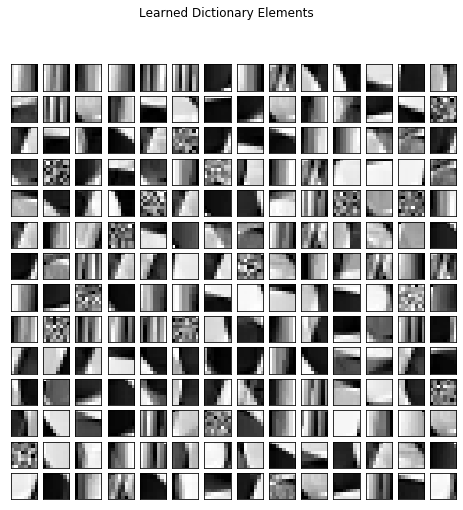

In [39]:
gridsize = int(np.sqrt(n_dictionary_elements))

plt.figure(figsize=(8, 8))
for i, comp in enumerate(learned_dictionary.components_[:gridsize**2]):
    plt.subplot(gridsize, gridsize, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Learned Dictionary Elements')
plt.show()

### Reconstruction With a Dictionary
Now what we'll do is split the noisy image into patches, and learn combinations of the clean patches for reconstruction. After reconstructing, we recombine and get our new image! Note that we first normalize the input patches by removing their means. Why don't we need the standard deviation normalization this time...?

/Users/dgilton/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


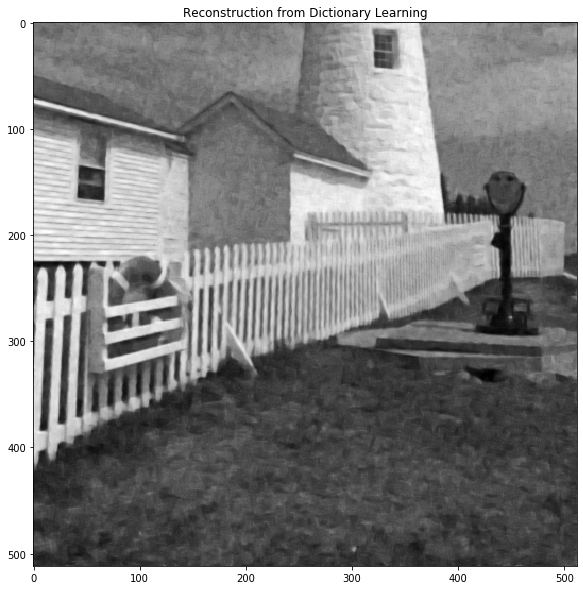

In [41]:
noisy_patches = extract_patches_2d(noisy_image, patch_size)
noisy_patches = noisy_patches.reshape(noisy_patches.shape[0], -1)
noisy_means = np.mean(noisy_patches, axis=0) # We need to store this for later
centered_noisy_patches = noisy_patches - noisy_means

patch_dictionary.set_params(transform_algorithm = 'omp')
noisy_patches_coefficients = patch_dictionary.transform(centered_noisy_patches)
reconstructed_patches = np.dot(noisy_patches_coefficients, learned_dictionary.components_)

reconstructed_patches += noisy_means
reconstructed_patches = reconstructed_patches.reshape(len(centered_noisy_patches), *patch_size)
reconstruction = reconstruct_from_patches_2d(reconstructed_patches, image_shape)

fig = plt.figure()
plt.imshow(reconstruction, cmap='gray'); plt.title('Reconstruction from Dictionary Learning')
plt.show()

## Deep Denoising
Now we will demonstrate the results you get when using a deep (residual) network to do denoising. Note that we actually define the class for the neural network - this is for illustration purposes and also because of a quirk in how PyTorch deals with loading models.

You may get scary-looking warnings as this runs - as long as the code completes you're okay. Neural network libraries are notorious for generating lots of warnings.

/Users/dgilton/anaconda3/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'deep_denoiser.DnCNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/dgilton/anaconda3/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/dgilton/anaconda3/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the obje

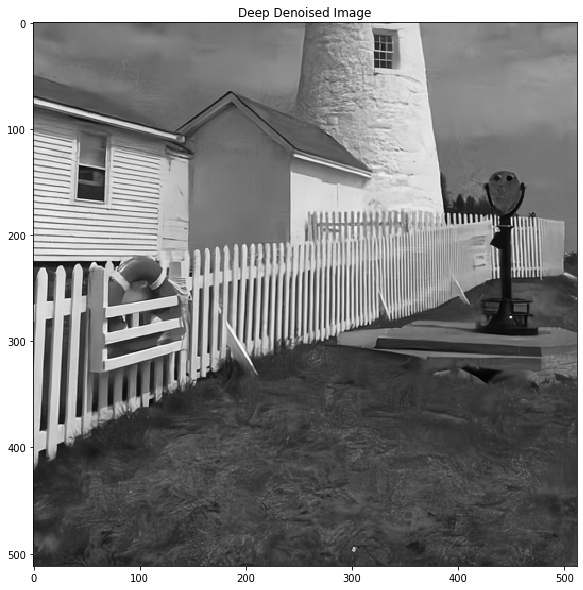

In [2]:
import deep_denoiser
from deep_denoiser import DnCNN

    
deep_denoised_reconstruction = deep_denoiser.denoise_with_network(noisy_image)

fig = plt.figure()
plt.imshow(deep_denoised_reconstruction, cmap='gray'); plt.title('Deep Denoised Image')
plt.show()

#### Residual Learning
If you examine the class definition, you may see that the network does not learn the clean image, but rather learns a *residual*. We can see what the network learns to produce via the following. Is the result just noise? You may also find it interesting to explore what kinds of residuals other methods produce. We included a line you can uncomment to look at the same result for dictionary learning.

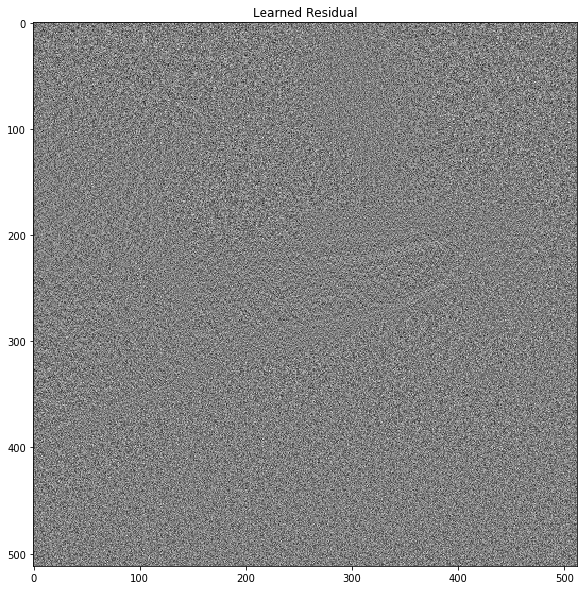

In [45]:
residual = noisy_image - deep_denoised_reconstruction
# residual = noisy_image - reconstruction
fig = plt.figure()
plt.imshow(residual, cmap='gray'); plt.title('Learned Residual')
plt.show()